# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Lab 4: Feature Engineering and Pipelines

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
<hr style='height:2px'>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer 
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from pandas.api.types import CategoricalDtype 
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
#from sklearn.linear_model import Ridge
#from sklearn.impute import SimpleImputer
#from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

In [2]:
# to display nice pipeline drawing
from sklearn import set_config
set_config(display="diagram") # instead of display='text'

## Can we predict the "market value" of prospective players in the Fantasy Premier League?
![trent](fig/trent.jpg) 
####  "... who knows"
<p style="text-align:right"><font size="1"; text-align='right'>(Image: Trent Alexander-Arnold https://www.premierleague.com/news/2766220)</font></p>

<a id=top></a>
### Lab Overview

This lab is divided into three parts:

REGULAR GAME (9:45 am - 11:00 am)
- [1 - Data exploration and preliminary feature selection.](#intro) (25min)<BR>
- [2 - Feature Engineering.](#engine)
    
OVERTIME (11:00 am - 11:30 am)
- [3 - Using Pipelines of transforms with a final estimator.](#pipes) 

<a id=intro></a> 
## 1 - Data exploration and preliminary feature selection 

### Story
Once Upon a Time, the Football Association gave us a dataset and asked us to help them predict the <b>market value</b> (what the player could earn when hired by a new team) of prospective players.

### The dataset
The dataset includes data up to 2017, and was created by [Shubham Maurya](https://www.kaggle.com/mauryashubham/linear-regression-to-predict-market-value/data) who used a variety of sources, including *transfermrkt.com* and *Fantasy Premier League (FPL)*, and a variety of methods, including scraping. 
Each observation is a collection of facts about players in the English Premier League. 

`name`             : Name of the player  
`club`             : Club of the player  
`age`              : Age of the player  
`position`         : The usual position on the pitch  
`position_cat`     : 1 for attackers, 2 for midfielders, 3 for defenders, 4 for goalkeepers   
`page_views`       : Average daily Wikipedia page views from September 1, 2016 to May 1, 2017  
`fpl_points`       : FPL points accumulated over the previous season (https://www.premierleague.com/news/2174909)<BR>
`region`           : 1 for England, 2 for EU, 3 for Americas, 4 for Rest of World  
`nationality`      : Player's nationality <BR>
`new_signing`      : Whether a new signing for 2017/18 (till 20th July)  
`new_foreign`      : Whether a new signing from a different league, for 2017/18 (till 20th July)  
`club_id`          : a numerical version of the Club feature  

### Our goal
To construct and fit a model that predicts the players' `market value` using all or part of the features in the given data.

### Our return variable

`market_value`: As on transfermrkt.com on July 20th, 2017 in £M (British pounds)
    

#### Import the data

In [3]:
league_df = pd.read_csv("data/league_data.csv")
league_df.head(2)

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3,Chile,0,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,167,2,Germany,0,1,0


In [4]:
league_df.shape

(460, 13)

#### Some statistics

In [5]:
league_df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,460,460,Alexis Sanchez,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
club,460,20,Arsenal,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,460.0,NaN,NaN,NaN,26.81087,3.964039,17.0,24.0,27.0,30.0,38.0
position,460,13,CB,85,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position_cat,460.0,NaN,NaN,NaN,2.178261,1.000417,1.0,1.0,2.0,3.0,4.0
market_value,460.0,NaN,NaN,NaN,11.018587,12.269941,0.05,3.0,7.0,15.0,75.0
page_views,460.0,NaN,NaN,NaN,764.6,932.652322,3.0,219.75,460.0,900.0,7664.0
fpl_points,460.0,NaN,NaN,NaN,57.336957,53.169454,0.0,5.0,51.0,94.0,264.0
region,460.0,NaN,NaN,NaN,1.993478,0.957689,1.0,1.0,2.0,2.0,4.0
nationality,460,61,England,156,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
league_df.describe(include=object).T

,count,unique,top,freq
name,460,460,Alexis Sanchez,1
club,460,20,Arsenal,28
position,460,13,CB,85
nationality,460,61,England,156


#### What about missing values?

In [7]:
league_df.isnull().sum()

name            0
club            0
age             0
position        0
position_cat    0
market_value    0
page_views      0
fpl_points      0
region          0
nationality     0
new_foreign     0
club_id         0
new_signing     0
dtype: int64

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 1 : </strong> Which features do we want to keep?</div>  
    
This should be a preliminary check for obvious features to include or excude. This is not the type of feature selection we would do using the model. These should be done after the train and test split. For example, are there features that are basically measuring the same thing?

Notice that the dataset contains columns with different data types. We need to apply a specific preprocessing for each one of them. Categorical variables that are ordinal need to be coded as integers, while the rest of them need to be one-hot-encoded. 

In [8]:
# remove
league_df.head(2)

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3,Chile,0,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,167,2,Germany,0,1,0


In [9]:
# remove
league_df.position.unique()

array(['LW', 'AM', 'GK', 'RW', 'CB', 'RB', 'CF', 'LB', 'DM', 'RM', 'CM',
       'SS', 'LM'], dtype=object)

In [10]:
# remove
league_df[['position','position_cat']].groupby(['position_cat']).agg({'position' : np.unique,
                                                        })

,position
position_cat,
1,"[AM, CF, LW, RB, RW, SS]"
2,"[CM, DM, LM, RM]"
3,"[CB, LB, RB]"
4,[GK]


In [11]:
# remove
league_df[['region','nationality']].groupby(['region']).agg({'nationality' : np.unique,
                                                        })

,nationality
region,
1,"[England, Wales]"
2,"[Argentina, Austria, Belgium, Bosnia, Cameroon..."
3,"[Argentina, Bermuda, Brazil, Canada, Chile, Co..."
4,"[Algeria, Armenia, Australia, Benin, Cameroon,..."


In [12]:
#remove
league_df.dtypes

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_points        int64
region            int64
nationality      object
new_foreign       int64
club_id           int64
new_signing       int64
dtype: object

In [13]:
# remove
categorical_cols = ['position_cat', 'new_signing', 'region'] 
numerical_cols = ['page_views', 'fpl_points', 'age'] 
ordinal_cols = [] # we do not have any

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 2 : </strong> Let's start with some feature engineering and construct a new feature: `big_club`.</div>  

The Football Association have a hunch that being in a **big club** affects the market value of a player, so they want us to construct and include this feature in our model. We also noticed that `club_id` had too many categories for one-hot-encoding.
<BR><BR>
Until 2017, big clubs were the following:
<BR>
    
```
'Arsenal', 'Chelsea', 'Liverpool', 'Manchester+City', 'Manchester+United', 'Tottenham'
```

Create a new binary categorical variable named `big_clubs` with values $0$ or $1$ designating if a club belongs to the Top 6 clubs.

#### NOTE: Applying functions to pandas Series
If the function to create the new column is simple, we may use a direct way to create the new column (feature), e.g.:

```
df['new_column'] = df['column']**2
```
If more complex operations we may use a `lambda` function.
```
df['new_column'] = df.apply(lambda row: 1 if row['column'] in big_clubs else 0, axis=1)
``` 

In [14]:
# remove
big_clubs = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester+City',
     'Manchester+United', 'Tottenham']

# creating a new column by applying a function in other columns
league_df['big_club'] = league_df.apply(lambda row: 1 \
                                         if row['club'] in big_clubs else 0, axis=1)

In [15]:
# check
league_df.head(2)

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing,big_club
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3,Chile,0,1,0,1
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,167,2,Germany,0,1,0,1


### Does being in a big club affect market value?

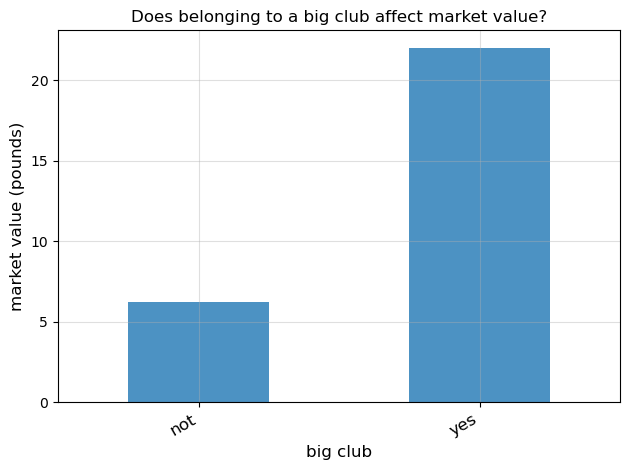

In [16]:
ax = league_df.groupby(['big_club']).market_value.mean()\
              .plot(kind='bar', alpha=0.8)
ax.set_xlabel('big club', fontsize=12)
ax.set_ylabel(r'market value (pounds)', fontsize=12)
ax.set_xticklabels(['not', 'yes'], #ax.get_xticklabels(), 
                   horizontalalignment="right",
                   fontsize=12, rotation=30)

ax.set_title('Does belonging to a big club affect market value?', fontsize=12)
ax.grid(":", alpha=0.4)

plt.tight_layout()

In [17]:
# do not forget to add 'big_club' to our features
# remove
categorical_cols = ['position_cat', 'new_signing', 'big_club', 'region'] 
numerical_cols = ['page_views', 'fpl_points', 'age'] 

In [18]:
# (optional) cast categorical variables as pandas type `category`
cat_type = CategoricalDtype(ordered=False)
for var in categorical_cols:
    league_df[var] = league_df[var].astype(cat_type)

<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 2 : </strong> Practice stratified train-test split. Stratify by `region`.</div>  

![test](fig/val.jpg) 

 #### Train-test split (with stratification)

We want to split before we do any EDA since, ideally, we do not want our test set to influence our design decisions. 

Also, we want to make sure that the training and test data have appropriate representation of certain variables; it would be bad for the training data or the test data to entirely miss a region, for example. This is especially important when some features are underrepresented (our data is **imbalanced**). To see the numbers in each category:

```
print(league_df['region'].value_counts().sort_index())
```

Use the `train_test_split` function and its `stratify` argument to split the data.
```
train and test subsets = sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
```
To stratify, we set the parameter `stratify` = league_df[region]

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

Note: This will not work if the dataset contains missing data.

In [19]:
# remove
league_df['position_cat'].value_counts()

1    154
3    152
2    112
4     42
Name: position_cat, dtype: int64

#### Designate response variable

In [20]:
# remove
response = 'market_value'
y = league_df[response]

In [21]:
# remove
seed = 42
train_data, test_data, y_train, y_test = train_test_split(
                                            league_df, y, 
                                            random_state=seed,
                                            stratify=league_df['region'],                                          
                                            test_size = 0.2, 
                                            )

train_data.shape, test_data.shape, y_train.shape, y_test.shape

((368, 14), (92, 14), (368,), (92,))

In [22]:
# check
train_data.head(2)

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing,big_club
228,Mamadou Sakho,Liverpool,27,CB,3,15.0,934,35,2,France,0,10,0,1
286,DeAndre Yedlin,Newcastle+United,24,RB,3,5.0,764,0,3,United States,0,13,0,0


In [23]:
# check
test_data.head(2)

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing,big_club
438,Robert Snodgrass,West+Ham,29,RW,1,8.0,1210,133,2,Scotland,0,20,0,0
303,Aleksandar Mitrovic,Newcastle+United,22,CF,1,10.0,781,0,2,Serbia,0,13,0,0


<a id=engine></a>  [Top](#top)
## 2 - Feature Engineering

#### Be careful! We want to work with only the features we chose! 

Notice the addition of `[cols]` when using the DataFrame.
```
train_data[cols]
```

In [24]:
cols = categorical_cols + numerical_cols

X_train = train_data[cols].copy()
X_test = test_data[cols].copy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((368, 7), (92, 7), (368,), (92,))

### Transform categorical variables 

We will use sklearn's `OneHotEncoder()` for converting categorical variables (ordinal and non-ordinal ) to one-hot encoded ones.

By default, it keeps all one-hot created columns. It has a fine-grained drop mechanism, can drop only binary variables, or the first in the list of categories).

```
drop{‘first’, ‘if_binary’}, default=None
```

It also has a mechanism for handling the presence of unknown categories in the test set. 
```
handle_unknown{‘error’, ‘ignore’}, default=’error’
```

In [25]:
print(f'Categorical non-ordinal: {categorical_cols}')
print(f'Numerical: {numerical_cols}')

Categorical non-ordinal: ['position_cat', 'new_signing', 'big_club', 'region']
Numerical: ['page_views', 'fpl_points', 'age']


In [26]:
drop_strategy = 'first'
unknown_strategy = 'ignore'

In [27]:
from sklearn.preprocessing import OneHotEncoder
# remove
ohe = OneHotEncoder(drop=drop_strategy, 
                    sparse=False, 
                    handle_unknown=unknown_strategy) 
ohe_train = ohe.fit_transform(X_train[categorical_cols])
type(ohe_train)

/usr/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


numpy.ndarray

In [28]:
ohe_train.shape, X_train[categorical_cols].shape

((368, 8), (368, 4))

In [29]:
# get the names of the newly created variables
ohe.get_feature_names_out()

array(['position_cat_2', 'position_cat_3', 'position_cat_4',
       'new_signing_1', 'big_club_1', 'region_2', 'region_3', 'region_4'],
      dtype=object)

In [30]:
# make into Dataframe
ohe_train_df = pd.DataFrame(ohe_train, columns=ohe.get_feature_names_out())
ohe_train_df.head(2)

,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Do not forget to `transform()` the test set; 

In [31]:
# remove
ohe_test = ohe.transform(X_test[categorical_cols])
ohe_test_df = pd.DataFrame(ohe_test, columns=ohe.get_feature_names_out())
ohe_test_df.head(2)

,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**OK**, our categorical variables are one-hot encoded and ready in `ohe_train_df` and `ohe_test_df`

### Transform numerical variables 

We will use sklearn's `StandardScaler`

In [32]:
# scaling
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()

# scale train set with ONLY the numerical values
# remove
scaled_train = scaler.fit_transform(X_train[numerical_cols])
scaled_train

array([[ 0.18607186, -0.42209325,  0.04328437],
       [ 0.00761631, -1.09402021, -0.70337094],
       [ 0.44745676, -1.09402021, -0.20560074],
       ...,
       [ 1.36282876, -0.71006194,  0.29216947],
       [ 0.62381283, -1.09402021, -0.20560074],
       [-0.36714035, -0.28770786, -0.20560074]])

In [34]:
# check
type(scaled_train)

numpy.ndarray

In [35]:
#The mean value for each feature in the training set
print(scaler.mean_)

[756.74456522  56.98641304  26.82608696]


In [36]:
# make into a Dataframe
# remove
scaled_train_df = pd.DataFrame(scaled_train, columns=numerical_cols)

In [37]:
# scale test set and make into a Dataframe
# remove
scaled_test = scaler.transform(X_test[numerical_cols]);
scaled_test_df = pd.DataFrame(scaled_test, columns=numerical_cols);

In [38]:
# check
scaled_train_df.head()

,page_views,fpl_points,age
0,0.186072,-0.422093,0.043284
1,0.007616,-1.094020,-0.703371
2,0.447457,-1.094020,-0.205601
3,-0.265316,-0.402895,-1.450026
4,-0.260067,0.710584,-0.952256


In [39]:
scaled_train_df.describe().head(3)

,page_views,fpl_points,age
count,3.680000e+02,3.680000e+02,3.680000e+02
mean,5.792468e-17,7.723291e-17,2.111837e-16
std,1.001361e+00,1.001361e+00,1.001361e+00


In [40]:
scaled_test_df.describe().head(3)

,page_views,fpl_points,age
count,92.000000,92.000000,92.000000
mean,0.041231,0.033649,-0.018937
std,0.888487,1.100229,0.930237


**OK**, our numerical variables are scaled and ready in `scaled_train_df` and `scaled_test_df`

### Include Polynomial Features and Interaction Terms

In [41]:
poly_deg = 2
include_bias = True  
fit_intercept = False  

# create the polynomial terms
# remove
poly = PolynomialFeatures(degree=poly_deg, 
                          interaction_only=False, # the default
                          include_bias=include_bias)

# Compute the polynomial features in train set
# remember to use the scaled Dataframe
poly_train = poly.fit_transform(scaled_train_df)

# Compute the polynomial features in test set
poly_test = poly.transform(scaled_test_df)
type(poly_train)

numpy.ndarray

In [42]:
# get the names 
poly.get_feature_names_out()

array(['1', 'page_views', 'fpl_points', 'age', 'page_views^2',
       'page_views fpl_points', 'page_views age', 'fpl_points^2',
       'fpl_points age', 'age^2'], dtype=object)

We get interaction terms for free! Whether we want them or not.

In [43]:
# make into DataFrame
# remove
poly_train_df = pd.DataFrame(poly_train, columns=poly.get_feature_names_out())
poly_train_df.head(2)

,1,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2
0,1.0,0.186072,-0.422093,0.043284,0.034623,-0.078540,0.008054,0.178163,-0.018270,0.001874
1,1.0,0.007616,-1.094020,-0.703371,0.000058,-0.008332,-0.005357,1.196880,0.769502,0.494731


In [44]:
# same for test
poly_test_df = pd.DataFrame(poly_test, columns=poly.get_feature_names_out())
poly_test_df.head(2)

,1,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2
0,1.0,0.475800,1.459302,0.541055,0.226385,0.694336,0.257434,2.129563,0.789562,0.29274
1,1.0,0.025462,-1.094020,-1.201141,0.000648,-0.027856,-0.030583,1.196880,1.314073,1.44274


#### Now, we need to add all the new variables to create the final design matrix.

In [45]:
# create the design matrix for the train set 
# remove
design_train_df = pd.concat([poly_train_df, ohe_train_df], axis=1)
design_train_df.head(2)

,1,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,1.0,0.186072,-0.422093,0.043284,0.034623,-0.078540,0.008054,0.178163,-0.018270,0.001874,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.007616,-1.094020,-0.703371,0.000058,-0.008332,-0.005357,1.196880,0.769502,0.494731,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
# same for the test set
# remove
pd.set_option('display.max_columns', None)
design_test_df = pd.concat([poly_test_df, ohe_test_df], axis=1)
design_test_df.head(2)

,1,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,1.0,0.475800,1.459302,0.541055,0.226385,0.694336,0.257434,2.129563,0.789562,0.29274,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.025462,-1.094020,-1.201141,0.000648,-0.027856,-0.030583,1.196880,1.314073,1.44274,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Now, time to train the model using our design matrix!

In [47]:
# Fit a linear regression model with fit_intercept=fit_intercept from previously
# remove
linreg = LinearRegression(fit_intercept=fit_intercept)
linreg.fit(design_train_df, y_train)

LinearRegression(fit_intercept=False)

In [48]:
# predict
y_test_pred = linreg.predict(design_test_df)
r2_train = linreg.score(design_train_df, y_train) # R^2
r2_test = linreg.score(design_test_df, y_test)

In [49]:
print(f'R^2 train = {r2_train:.3}')
print(f'R^2 test = {r2_test:.3}')

R^2 train = 0.763
R^2 test = 0.828


In [50]:
# the calculated coefficients
linreg.coef_

array([ 8.07702577,  4.88579557,  2.50525789, -1.32107865, -0.1722304 ,
        0.70903118, -1.180761  ,  0.90515742, -0.17899494, -1.80176777,
        0.82019569, -0.51567709, -0.7639615 ,  1.45567537,  6.56477776,
        1.82628104,  2.16905843,  1.05015518])

In [51]:
# create a results dataframe by combining the features names with the coefficients
# remove
print(f'Intercept: {linreg.intercept_:.3}')
results = pd.DataFrame(zip(design_train_df.columns, linreg.coef_), columns=['feature', 'coeff'])
results

Intercept: 0.0


,feature,coeff
0,1,8.077026
1,page_views,4.885796
2,fpl_points,2.505258
3,age,-1.321079
4,page_views^2,-0.172230
5,page_views fpl_points,0.709031
6,page_views age,-1.180761
7,fpl_points^2,0.905157
8,fpl_points age,-0.178995
9,age^2,-1.801768


## Can we predict Jeffrey Schlupp's fantasy market value?
<div class="alert alert-success">
    <strong>🏋🏻‍♂️ ACTIVITY 3 : </strong> You are given the feature values for Jeffrey Schlupp.</div><BR>

This data is in a file named `data/jeffrey.csv`, which contains a DataFrame with a single row (a DataFrame, nontheless). Can you predict his market value?  His real `market value` is 8, but you do not know that. We will come back to this value to compare with the prediction. 
 
![jeffrey](fig/JeffreySchlupp.jpg) 

In [52]:
jeffrey_df = pd.read_csv("data/jeffrey.csv")
jeffrey_df

,name,club,age,position,position_cat,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing
0,Jeffrey Schlupp,Crystal+Palace,24,LB,3,385,47,4,Ghana,0,6,0


#### We have to perform all the preprocessing from scratch!

In [53]:
# remove
jeffrey_df['big_club'] = jeffrey_df.apply(lambda row: 1 \
                                         if row['club'] in big_clubs else 0, axis=1)

In [54]:
# one-hot encode and make into a Dataframe
# remove
ohe_jeffrey = ohe.transform(jeffrey_df[categorical_cols])
ohe_jeffrey_df = pd.DataFrame(ohe_jeffrey, columns=ohe.get_feature_names_out())

In [55]:
# scale test set and make into a Dataframe
# remove
scaled_jeffrey = scaler.transform(jeffrey_df[numerical_cols]);
scaled_jeffrey_df = pd.DataFrame(scaled_jeffrey, columns=numerical_cols);

In [56]:
# one-hot encode and make into a Dataframe
# remove
ohe_jeffrey = ohe.transform(jeffrey_df[categorical_cols])
ohe_jeffrey_df = pd.DataFrame(ohe_jeffrey, columns=ohe.get_feature_names_out())

In [57]:
# Compute the polynomial features and make into a Dataframe
# remove
poly_jeffrey = poly.transform(scaled_jeffrey_df)
poly_jeffrey_df = pd.DataFrame(poly_jeffrey, columns=poly.get_feature_names_out())

In [58]:
# create the design matrix for the jeffrey set 
# remove
design_jeffrey_df = pd.concat([poly_jeffrey_df, ohe_jeffrey_df], axis=1)
design_jeffrey_df

,1,page_views,fpl_points,age,page_views^2,page_views fpl_points,page_views age,fpl_points^2,fpl_points age,age^2,position_cat_2,position_cat_3,position_cat_4,new_signing_1,big_club_1,region_2,region_3,region_4
0,1.0,-0.390235,-0.191718,-0.703371,0.152283,0.074815,0.27448,0.036756,0.134849,0.494731,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [59]:
# Predict using existing linear regression model
y_jeffrey_pred = linreg.predict(design_jeffrey_df)
print(f'Prediction: {y_jeffrey_pred[0]:.3}')

Prediction: 5.97


<a id=pipes></a>  [Top](#top)
## 3 - Using Pipelines of transforms with a final estimator

There could be many transformations that need to be executed sequentialy in order to construct the design matrix. As we saw, it is possible to handcraft the design matrix ourselves by transforming individual columns, it is more efficient and error-free to create an sklearn `pipeline` to do this for you. Sklearn can work directly with `numpy` arrays or pandas `DataFrames`. 

When using the latter, `sklearn.compose.ColumnTransformer` is useful, as it applies transformers to columns of an array or pandas DataFrame. This estimator allows different columns or column subsets of the input to be transformed separately and the features generated by each transformer will be concatenated to form the design matrix.

#### Making a pipeline

```
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

my_pipeline = Pipeline([
        ('imputer', Imputer(strategy='median')),      # we will be using later
        ('std_scaler', StandardScaler()),             # optional
        ('selector', ColumnTransformer())             # for one-hot encoding
        ('regressor', lr)                             # actual regressor model
])
```

#### Beginning to end machine learning using `pipeline` 

In [60]:
league_df = pd.read_csv("data/league_data.csv")
league_df.head(2)

,name,club,age,position,position_cat,market_value,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,264,3,Chile,0,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,167,2,Germany,0,1,0


In [61]:
response = 'market_value'
y = league_df[response]

In [62]:
train_data, test_data, y_train, y_test = train_test_split(
                                            league_df, y, 
                                            random_state=seed,
                                            stratify=league_df['position_cat'],
                                            test_size = 0.2)

In [63]:
from sklearn.impute import SimpleImputer
class DataframeTransformer():
    def __init__(self, func):
        self.func = func

    def transform(self, input_df, **params):
        return self.func(input_df)

    def fit(self, X, y=None, **fit_params):
        return self

# modify data frame to create new columns
def process_dataframe(df):
    big_clubs = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester+City',
     'Manchester+United', 'Tottenham']
    
    df['big_club'] = df.apply(lambda row: 1 \
                                if row['club'] in big_clubs else 0, axis=1)  
    
    return df[categorical_cols+numerical_cols]

categorical_cols = ['position_cat', 'new_signing', 'big_club', 'region'] 
numerical_cols = ['page_views', 'fpl_points'] 

# arguments for one-hot encoder
drop_strategy = 'first'
unknown_strategy = 'ignore'

# transform categoricals, alternatives: drop='if_binary', 'first', handle_unknown='error'
categorical_preprocessor = OneHotEncoder(drop=drop_strategy, 
                                         sparse=False,
                                         handle_unknown=unknown_strategy) 

# arguments for Polynomial features
poly_deg = 2
include_bias = True
fit_intercept = False

# transform numericals
numeric_preprocessor = Pipeline([
                    #('imputer', SimpleImputer(fill_value=0.0)), # for later
                    ('stdscaler', StandardScaler()),
                    ('polynomial', PolynomialFeatures(degree=poly_deg, 
                                                      include_bias=include_bias)),                             
])

# bring all transformations together
preprocessor = ColumnTransformer([
               ('cat', categorical_preprocessor, categorical_cols),
              #('reduce_dim', PCA(n_components=4)) # for later
               ('num', numeric_preprocessor, numerical_cols)
])

model = Pipeline([
                 ('big_clubs', DataframeTransformer(process_dataframe)),
                 ('preprocessor', preprocessor),
                 ('regressor', LinearRegression(fit_intercept=fit_intercept))
])

model.fit(train_data, y_train)
print(f'R^2 on train set: {model.score(train_data, y_train):.3}') # R^2
print(f'R^2 on test set: {model.score(test_data, y_test):.3}') # R^2
model

R^2 on train set: 0.709
R^2 on test set: 0.732


/usr/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('big_clubs',
                 <__main__.DataframeTransformer object at 0x7f0cf1869f10>),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['position_cat',
                                                   'new_signing', 'big_club',
                                                   'region']),
                                                 ('num',
                                                  Pipeline(steps=[('stdscaler',
                                                                   StandardScaler()),
                                                                  ('polynomial',
                                                                   PolynomialFeatures())]),
                                                  ['page_views',
                                                   'fpl_points'])])),
                ('regressor', LinearRegression(fit_intercept=False))])

In [64]:
# grab the linear regressor
linear_regressor = model.named_steps['regressor']
linear_regressor.intercept_, linear_regressor.coef_

(0.0,
 array([ 0.92723291, -0.00882128, -1.59779194,  2.46830241,  8.01389853,
         1.67872629,  1.91760344,  2.43550242,  5.43626528,  4.12534725,
         3.02051612, -0.18000918,  1.20007183,  0.81198801]))

In [65]:
ohe = (model.named_steps['preprocessor'].named_transformers_['cat'])
ohe_names = ohe.get_feature_names_out(input_features=categorical_cols)
scaler_names = model.named_steps['preprocessor'].transformers_[1][1]\
                    .named_steps['polynomial'].get_feature_names_out(numerical_cols)
feature_names = np.r_[ohe_names, scaler_names]
feature_names = list(feature_names)
feature_names

['position_cat_2',
 'position_cat_3',
 'position_cat_4',
 'new_signing_1',
 'big_club_1',
 'region_2',
 'region_3',
 'region_4',
 '1',
 'page_views',
 'fpl_points',
 'page_views^2',
 'page_views fpl_points',
 'fpl_points^2']

In [66]:
print(f'Intercept: {linear_regressor.intercept_:.3}')
pd.DataFrame(zip(feature_names, linear_regressor.coef_), columns=['feature', 'coeff'])

Intercept: 0.0


,feature,coeff
0,position_cat_2,0.927233
1,position_cat_3,-0.008821
2,position_cat_4,-1.597792
3,new_signing_1,2.468302
4,big_club_1,8.013899
5,region_2,1.678726
6,region_3,1.917603
7,region_4,2.435502
8,1,5.436265
9,page_views,4.125347


### Can we again predict Jeffrey Schlupp's fantasy market value using pipelines?

In [67]:
jeffrey_df = pd.read_csv("data/jeffrey.csv")
jeffrey_df

,name,club,age,position,position_cat,page_views,fpl_points,region,nationality,new_foreign,club_id,new_signing
0,Jeffrey Schlupp,Crystal+Palace,24,LB,3,385,47,4,Ghana,0,6,0


### It's a ONE LINER!!

In [68]:
single_pred = model.predict(jeffrey_df)
print(f'Prediction: {single_pred[0]:.3}')

Prediction: 5.76


## Appendix 

### Machine Learning libraries

Two of the most popular Python libraries used in data science and machine learning are:

1. `Scikit-learn (sklearn)` is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection, model evaluation, and many other utilities. `sklearn` is focused on the _prediction_ task: given \[new\] data, guess what the response value is.  

2. `statsmodels` is focused on the _inference_ task: guess good values for the betas and discuss how certain you are in those answers. 

For more of their similarities and differences see article in medium.com: [Linear Regression in Scikit-learn vs Statsmodels]( https://medium.com/@hsrinivasan2/linear-regression-in-scikit-learn-vs-statsmodels-568b60792991)

### A more generic way of creating a new column is by applying a function (any function) on other columns
e.g.
```
df['new_column'] = df.apply(lambda row: func(row, 'column', args), axis=1)
```  

In [69]:
big_clubs = ['Arsenal', 'Chelsea', 'Liverpool', 'Manchester+City',
     'Manchester+United', 'Tottenham']

def is_big_club(dataframe, club, list_of_big_clubs):
    """
    Check if a club belongs to the list of big clubs
    """    
    return 1 if dataframe[club] in list_of_big_clubs else 0


# creating a new column by applying a function in other columns
league_df['big_club'] = league_df.apply(lambda row: \
                                         is_big_club(row, 'club', big_clubs), 
                                         axis=1) 

In [70]:
# pandas magic

In [71]:
position_df = train_data.groupby('position').agg({
                                'market_value': np.mean,
                                'page_views': np.median,
                                'fpl_points': np.max
})
position_df.sort_values(by='market_value', ascending=False)

,market_value,page_views,fpl_points
position,,,
AM,24.500000,1001.5,199
LW,13.693333,492.0,264
CF,12.688776,742.0,196
RW,11.375000,508.0,162
SS,11.357143,997.0,180
CM,11.348039,432.0,149
DM,10.767857,513.5,131
CB,9.083088,327.5,127
RM,8.666667,139.0,83


### Using pandas `get_dummies()`

By default keeps all $k$ dummies out of $k$ categorical levels. Can be made to remove the first level, so that we have $k-1$ dummies.
```
dummies_train = pd.get_dummies(train_data[categorical_cols], drop_first=True)
```

**Note**: if the test dataset has a category that does not exist in the training set, this will throw an error.

In [72]:
# age_bins = [16, 21, 24, 27, 31, 33, 38]
# age_labels = [1, 2, 3, 4, 5, 6]
# league_df['age_cat'] = pd.cut(x=league_df['age'],\
#                                  bins=age_bins, 
#                                  labels=age_labels) 

In [73]:
# BINARY - 'new' {0,1}: {0:A1, 1:A2}
# df['new'] = np.where(df['old'] == 'A1', 0, 1)

# # BINARY - 'new' {0,1}: {0: normal+cr, 1: ch+eh}  
# # decision to put missing values = 0, basically ignoring
# A_dict = {'A1': 0,'A2': 1, 'A3': 3, 'A4': 4, None:0} 
# df['new'] = [df[item] for item in df['old']]

In [74]:
# (optional) reset indices 
# train_data.reset_index(inplace=True, drop=True)
# test_data.reset_index(inplace=True, drop=True)
# y_train.reset_index(inplace=True, drop=True)
# y_test.reset_index(inplace=True, drop=True)

In [75]:
#plt.scatter(X_train['age'], y_train)